Lab 5
var 5
Model training and testing.

Библиотеки

In [1]:
import torch
import os
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from PIL import Image 
import torch.nn as nn
from torch.utils.data import *
import torch.optim as optim
import torch.nn.functional as F
import random

In [2]:
'''
Определяет, будет ли использоваться устройство "cuda" (если доступно) или "cpu" 
Устанавливает seed для генерации случайных чисел и выводит выбранное устройство.
'''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cpu


Разделение набора данных на выборки

In [3]:
'''
Создает кастомный датасет для обработки изображений. Класс `CustomDataset` наследует от `torch.utils.data.Dataset` и определяет методы `__init__`, `__len__` и `__getitem__`.
Он загружает изображения из файлового списка, применяет преобразования (если они указаны) и возвращает преобразованные изображения с соответствующими метками.

Создаются экземпляры кастомного датасета для обучающего, тестового и валидационного наборов данных, используя соответствующие списки файлов и преобразования.

Выводит информацию о втором элементе из обучающего датасета и метке первого элемента из валидационного датасета.
'''
val_path = os.path.abspath('val_list')
test_path = os.path.abspath('test_list')
train_path = os.path.abspath('train_list')

df = pd.read_csv('annotations_3.csv', sep=',', header=None)
df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'Absolute_path', 2: 'Class'}, inplace=True)
df.reset_index(inplace=True)
print(df)

for path in [val_path, test_path, train_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

def load_image(df, path, i):
    image_path = os.path.abspath(os.path.join(*df.Absolute_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

for i in range(900, 1000):
    load_image(df, val_path, i)
for i in range(1900, 1999):
    load_image(df, val_path, i)
for i in range(800, 900):
    load_image(df, test_path, i)
for i in range(1800, 1900):
    load_image(df, test_path, i)
for i in range(800):
    load_image(df, train_path, i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index            Absolute_path       Class
0         1  dataset_random/5446.jpg  brown bear
1         2  dataset_random/5929.jpg  brown bear
2         3  dataset_random/6474.jpg  brown bear
3         4    dataset_random/82.jpg  brown bear
4         5  dataset_random/1088.jpg  brown bear
...     ...                      ...         ...
1995   1996  dataset_random/5090.jpg  polar bear
1996   1997  dataset_random/7265.jpg  polar bear
1997   1998  dataset_random/1002.jpg  polar bear
1998   1999  dataset_random/2049.jpg  polar bear
1999   2000  dataset_random/6781.jpg  polar bear

[2000 rows x 3 columns]


Проверка

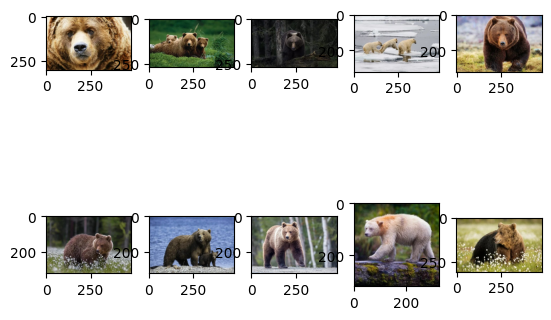

In [4]:
'''
Генерирует 10 случайных индексов из диапазона от 0 до 199 без повторений
Отображает изображения из обучающего списка с использованием библиотеки matplotlib.
'''
random_idx = np.random.choice(200, size=10, replace=False)

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_list[random_idx[i]])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

Увелечение изображений

In [5]:
'''
Определяет наборы преобразований для обучающего, валидационного и тестового наборов данных
таких как изменение размера, случайное обрезание, горизонтальное отражение и преобразование в тензоры.
'''
common_transforms = [
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ]

train_transforms = transforms.Compose(common_transforms)
val_transforms = transforms.Compose(common_transforms)
test_transforms = transforms.Compose(common_transforms)

Загрузка 

In [6]:
'''
Определяет пути к директориям для валидационного, тестового и обучающего наборов данных.
Считывает и предобрабатывает CSV-файл с аннотациями, затем создает директории, если они не существуют.
Определяет функцию для загрузки и сохранения изображений.
Обрабатывает изображения на основе заданных диапазонов.
Создает списки файлов изображений и разделяет обучающий список на обучающий и валидационный наборы данных.
'''
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = img

        label = 1 if 'brown bear' in img_path else 0 
        return img_transformed, label

In [7]:
'''
Создание кастомного датасета для обучения, тестирования и валидации модели
C использованием предварительно определенных преобразований.
'''
train_data = CustomDataset(train_list, transform=train_transforms)
test_data = CustomDataset(test_list, transform=test_transforms)
val_data = CustomDataset(val_list, transform=val_transforms)

Проверка

In [8]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.6745, 0.6745, 0.6706,  ..., 0.4392, 0.4471, 0.4471],
         [0.6745, 0.6745, 0.6706,  ..., 0.4392, 0.4471, 0.4471],
         [0.6745, 0.6745, 0.6706,  ..., 0.4471, 0.4510, 0.4510],
         ...,
         [0.9255, 0.9255, 0.9216,  ..., 0.7098, 0.7255, 0.7255],
         [0.9294, 0.9294, 0.9294,  ..., 0.7059, 0.7176, 0.7176],
         [0.9294, 0.9294, 0.9294,  ..., 0.7059, 0.7176, 0.7176]],

        [[0.6039, 0.6039, 0.6000,  ..., 0.4078, 0.4118, 0.4118],
         [0.6039, 0.6039, 0.6000,  ..., 0.4078, 0.4118, 0.4118],
         [0.6039, 0.6039, 0.6000,  ..., 0.4157, 0.4196, 0.4196],
         ...,
         [0.8863, 0.8863, 0.8784,  ..., 0.6431, 0.6627, 0.6627],
         [0.8863, 0.8863, 0.8824,  ..., 0.6392, 0.6549, 0.6549],
         [0.8863, 0.8863, 0.8824,  ..., 0.6392, 0.6549, 0.6549]],

        [[0.4549, 0.4549, 0.4510,  ..., 0.1333, 0.1333, 0.1333],
         [0.4549, 0.4549, 0.4510,  ..., 0.1333, 0.1333, 0.1333],
         [0.4510, 0.4510, 0.4471,  ..., 0.1412, 0.1412, 0

Обучение

In [9]:
lr = 0.001
batch_size = 10
epochs = 10

In [10]:
def create_loaders():
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
    return (train_loader, test_loader, val_loader)

train_loader, test_loader, val_loader = create_loaders()

In [11]:
print(len(train_data), len(train_loader))

720 72


In [12]:
print(len(val_data), len(val_loader))

80 8


Построение модели

In [13]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv,self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(3*3*64,10),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(10,2)
        )

    def forward(self,x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out

In [14]:
model = Conv().to(device)
model.train()

Conv(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=10, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [15]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

720 72
80 8


torch.Size([3, 224, 224])

task 5-6

Epoch : 1, train acc : 0.9875003695487976, train loss : 0.20136821269989014
Epoch : 1, val_acc : 1.0, val_loss : 0.08341416716575623
Epoch : 2, train acc : 1.0000003576278687, train loss : 0.07497846335172653
Epoch : 2, val_acc : 1.0, val_loss : 0.05000876635313034
Epoch : 3, train acc : 1.0000003576278687, train loss : 0.06700707972049713
Epoch : 3, val_acc : 1.0, val_loss : 0.08056844025850296
Epoch : 4, train acc : 1.0000003576278687, train loss : 0.05556686595082283
Epoch : 4, val_acc : 1.0, val_loss : 0.06414489448070526
Epoch : 5, train acc : 1.0000003576278687, train loss : 0.07200421392917633
Epoch : 5, val_acc : 1.0, val_loss : 0.07252362370491028
Epoch : 6, train acc : 1.0000003576278687, train loss : 0.06261922419071198
Epoch : 6, val_acc : 1.0, val_loss : 0.06837102770805359
Epoch : 7, train acc : 1.0000003576278687, train loss : 0.06263071298599243
Epoch : 7, val_acc : 1.0, val_loss : 0.02151152677834034
Epoch : 8, train acc : 1.0000003576278687, train loss : 0.05201915651

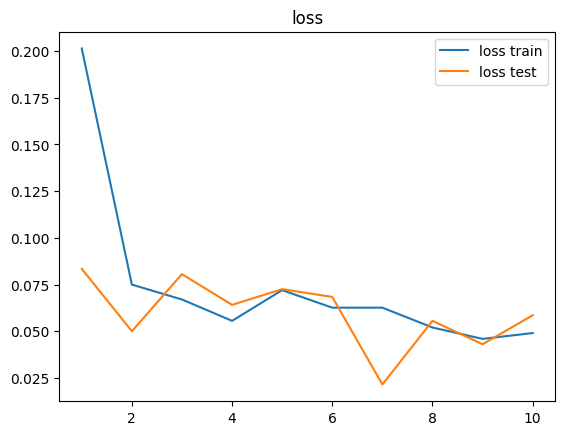

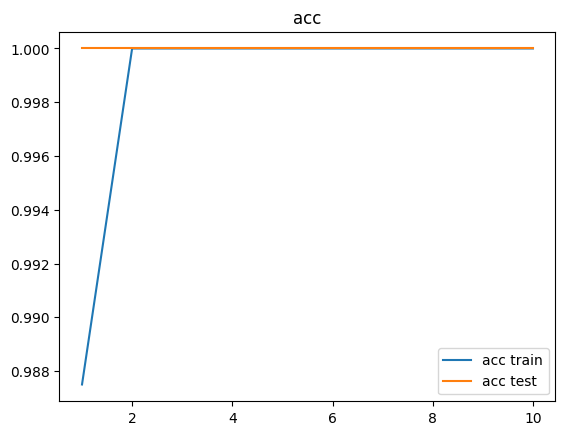

In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

def train(model, epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  epoch_val_acc_list = []
  epoch_val_loss_list = []
  epoch_acc_list = []
  epoch_loss_list = []

  for epoch in range(epochs):
      epoch_loss = 0
      epoch_acc = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_acc += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train acc : {}, train loss : {}'.format(epoch+1, epoch_acc,epoch_loss))
      epoch_acc_list.append(epoch_acc)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_acc=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)

              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_acc += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_acc : {}, val_loss : {}'.format(epoch+1, epoch_val_acc,epoch_val_loss))

      epoch_val_acc_list.append(epoch_val_acc)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_acc_list,epoch_val_loss_list,
  epoch_acc_list,
  epoch_loss_list)

epoch_val_acc_list, epoch_val_loss_list, epoch_acc_list, epoch_loss_list = train(model, epochs)

def show_plot(lis, list_val, text):
  x = list(range(1, len(lis)+ 1))
  plt.plot(x, lis, label = text+" train")
  plt.plot(x, list_val, label = text+" test")
  plt.title(text)
  plt.legend()
  plt.show()

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "loss")
show_plot(epoch_acc_list, epoch_val_acc_list, "acc")

Epoch : 1, train acc : 1.0000003576278687, train loss : 0.042042043060064316
Epoch : 1, val_acc : 1.0, val_loss : 0.04714694619178772
Epoch : 2, train acc : 1.0000003576278687, train loss : 0.049756769090890884
Epoch : 2, val_acc : 1.0, val_loss : 0.05296601727604866
Epoch : 3, train acc : 1.0000003576278687, train loss : 0.038976505398750305
Epoch : 3, val_acc : 1.0, val_loss : 0.03904621675610542
Epoch : 4, train acc : 1.0000003576278687, train loss : 0.04151856526732445
Epoch : 4, val_acc : 1.0, val_loss : 0.03723714500665665
Epoch : 5, train acc : 1.0000003576278687, train loss : 0.03484810143709183
Epoch : 5, val_acc : 1.0, val_loss : 0.01786699891090393
Epoch : 6, train acc : 1.0000003576278687, train loss : 0.03497220203280449
Epoch : 6, val_acc : 1.0, val_loss : 0.04790328070521355
Epoch : 7, train acc : 1.0000003576278687, train loss : 0.030208107084035873
Epoch : 7, val_acc : 1.0, val_loss : 0.02628684788942337
Epoch : 8, train acc : 1.0000003576278687, train loss : 0.0332845

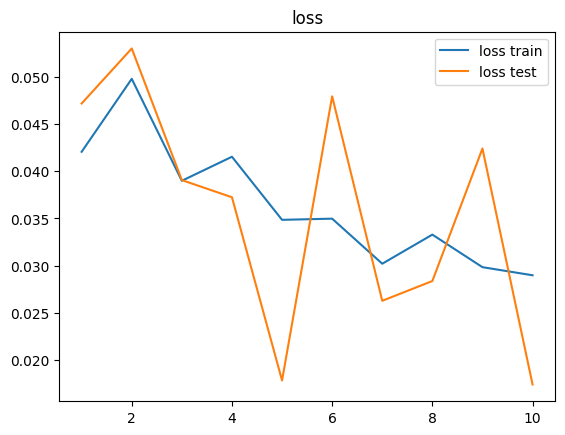

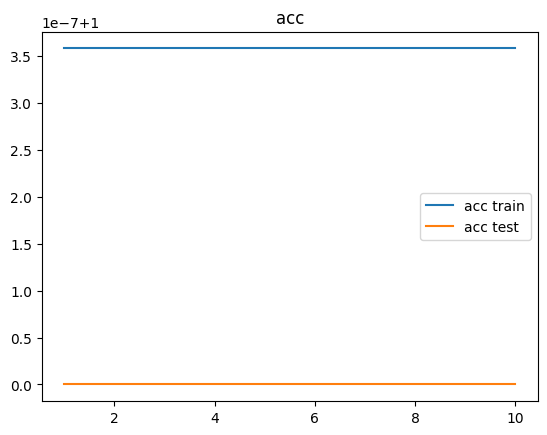

In [18]:
lr = 0.0005 # lr
batch_size = 10 # we will use mini-batch method

train_loader, test_loader, val_loader = create_loaders()

epoch_val_acc_list, epoch_val_loss_list, epoch_acc_list, epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "loss")
show_plot(epoch_acc_list, epoch_val_acc_list, "acc")